## **Bin packing**
___
- Encontrar el minimo de contenedores posibles considerando 5 tamaños de cajas (fijos)
- Considerar área de los contenedores, dimensiones de los paquetes, numero de paquetes, maximo 10 contenendores
___

### **PARAMETROS FIJOS INICIALES**: 
___
* **5 tamaños de cajas (fijos)**
    - 1000 cajas al día:
        + _Entradas_ : Número de cajas de cada tamaño (Colocar # cajas 1,2,3,4 y asignar el resto a la 5)

* **Restricciones :**
    - Comenzar por las cajas más grandes
    - El ancho de los paquetes siempre es fijo (1/3 del ancho del contenedor) 
    - Contar la cantidad de paquetes de cada tipo que restan por colocar
    - Registrar qué y cuántos paquetes van en cada contenedor
    - Siempre debe haber por lo menos un número mínimo de paquetes de cada tipo (asegurado)

* **Área de las cajas:**
    - Ancho de la caja: 1/3 de del contenedor ( 2.4 / 3 ) = 0.8 mts
    - Alto  de la caja:
        + _Caja 1_: 2 mts
        + _Caja 2_: 3 mts
        + _Caja 3_: 5 mts
        + _Caja 4_: 6 mts
        + _Caja 5_: 8 mts

* **Área de los contenedores:**
    - 12 mts x 2.4 mts ( alto x ancho )

* **Aptitud: minimo global de contenedores**
___

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random
import copy

In [87]:
# Función para generar la cantidad de cajas de cada tipo a ser acomodadas en contenedores
def genera_cajas( n = 1000):
    cant_cajas = []
    while True:
        cant_cajas.append(random.randint( (n/5) -50, (n/5) + 50)) #Genera 200 cajas de cada tipo, con una variación de +/-50
        if len(cant_cajas) == 4:
            cant_cajas.append( n - sum(cant_cajas) )
            break
    return cant_cajas

In [88]:
def generar_poblacion(total_cajas= genera_cajas(), ct = [2,3,5,6,8], cant_pobladores = 100):
    
    ## Codificación para cada contenedor
    contenedor = {
        "COL_CONT": [12, 12, 12],       # Espacio sin ocupar en cada columna del contenedor (espacio libre)
        "TOT_CAJ": np.array([0, 0, 0, 0, 0]),     # Cantidad de cajas de cada tipo en el contenedor
        "TOT_CAJ_COL": [                # Cantidad de cada tipo de caja por columna del contenedor
            np.array([0, 0, 0, 0, 0]),                       # Columna 1
            np.array([0, 0, 0, 0, 0]),                       # Columna 2
            np.array([0, 0, 0, 0, 0])                        # Columna 3
        ]
    }    

    POBLACION = [] # Lista para almacenar a toda la población generada
    Flag = True # Bandera de decisión para rellenar cada contenedor

    for p in range(cant_pobladores): # Recorre uno a uno, los números del 0 a la cantidad de pobladores especificada, para generarlos
        
        INDIVIDUO = []
        cant_cajas = total_cajas.copy() # Para cada poblador, las cajas iniciales serán las mismas
        cajas_elegibles = [0,1,2,3,4]
        total_cajas_actuales = np.array([0]*5)

        while(cajas_elegibles):
            cont_ = copy.deepcopy(contenedor) # Copia la estructura del diccionario
            for columna in range(3): # Para rellenar cada columna del contenedor
                
                while (Flag):

                    if (cajas_elegibles):
                        pesos = np.array(ct)
                        caja = random.choices(cajas_elegibles, weights = np.array(pesos[cajas_elegibles]), k=1 )[0]
                        #caja = random.choices(cajas_elegibles, k=1 )[0] # Se escoge una caja de manera aleatoria. METODO ALTERNATIVO DE SELECCION DE POBLACION
                    else:
                        break
                    # Si el total de las cajas contadas es mayor o igual que la cantidad de cajas de ese tipo a acomodar, elimina dicho tipo
                    # de caja para evitar sobrepasar la cantidad de cajas a acomodar
                    if( total_cajas_actuales[caja] >= cant_cajas[caja] ):
                        cajas_elegibles.remove(caja)
                    else:
                        # Calcula el espacio disponible (Es decir, el espacio vacío, en caso de acomodar la caja elegida actualmente)
                        espacio = cont_["COL_CONT"][columna] - ct[caja]
                        # Si la caja cabe (es decir, aún hay espacio vacío o éste no es negativo) se coloca y actualizan los conteos
                        if ( ( espacio >= 0) and (cajas_elegibles) ):
                            cont_["COL_CONT"][columna] -= ct[caja] # Conteo del espacio total por columna del contenedor disponible
                            cont_["TOT_CAJ_COL"][columna][caja] += 1 # Conteo de total de cajas por columna del contenedor
                            total_cajas_actuales[caja] += 1 #Total de cajas acomodadas en el total de contenedores actuales
                        #else:#METODO ALTERNATIVO DE SELECCION DE POBLACION
                        if cont_["COL_CONT"][columna] - min(pesos[cajas_elegibles]) < 0: # Condición para colocar todas las cajas que quepan en la columna, si aun existen cajas que quepan en existencia
                           break

            cont_["TOT_CAJ"] = np.sum(cont_["TOT_CAJ_COL"], axis = 0) # Total de cajas en el contenedor actual

            INDIVIDUO.append(cont_) 
        POBLACION.append(INDIVIDUO) 
    return POBLACION
            

In [89]:
def cuenta_cajas(hijo):
    # Función que cuenta el total de cajas, contenedor por contenedor, en el individuo actual
    contenedores_totales = np.array([0]*5)
    
    for conten in hijo:
        contenedores_totales += conten['TOT_CAJ']
        
    return contenedores_totales

In [90]:
def cuenta_espacios_vacios(hijo):
    # Función que cuenta el total de espacios vacíos, contenedor por contenedor, en el individuo actual
    contenedores_totales = 0
    
    for conten in hijo:
        contenedores_totales += np.sum( conten['COL_CONT'])

    return contenedores_totales - np.sum(hijo[-1]['COL_CONT'])

In [91]:
def evaluacion_aptitud(poblacion):
    #Función que evalúa la aptitud de cierto número de pobladores después de decodificarla.
    matriz_con_aptitud = pd.DataFrame()
    #aptitud = [len(poblador) for poblador in poblacion]
    aptitud = [ cuenta_espacios_vacios(poblador) + len(poblador) for poblador in poblacion]
    matriz_con_aptitud["POBLACION"] = poblacion # Lista de Diccionarios que contiene la cantidad de cada individuo por contenedor
    matriz_con_aptitud["APTITUD"] = aptitud 
    return matriz_con_aptitud

In [92]:
def cruza_homog(padre1, padre2, c, tc):
    # Función para cruzar los individuos de manera semihomogénea: es decir, individuo + porción independiente 
    #cajas_tam = [2, 3, 5, 6, 8]

    umbral = c.copy()
    num_genes = min(len(padre1), len(padre2))
    hijo_1 = []
    hijo_2 = []

    control = control1 = control2 = True
    
    cantidad_cajas = np.array([0] * 5) 
    cantidad_cajas2 = np.array([0] * 5)

    for i in range(num_genes):

        gen_padre = random.randint(0, 1)
        
        if(control):
            if (gen_padre == 0):
                    hijo_1.append(padre1[i])
                    hijo_2.append(padre2[i])
            else:
                    hijo_1.append(padre2[i])
                    hijo_2.append(padre1[i])
        else:
             break
        
        auxiliar = cuenta_cajas(hijo_1)
        auxiliar2 = cuenta_cajas(hijo_2)

        cantidad_cajas = auxiliar
        cantidad_cajas2 = auxiliar2

        resultado_h1 = np.any(cantidad_cajas > umbral)
        resultado_h2 = np.any(cantidad_cajas2 > umbral)

        
        if (resultado_h1 and control1):
            hijo_1.pop()
            cantidad_cajas = cuenta_cajas(hijo_1)
            control1 = False


        if (resultado_h2 and control2):
            hijo_2.pop()
            cantidad_cajas2 = cuenta_cajas(hijo_2)
            control2 = False
        
        if (not control1 or not control2):
             control = False
    
    restante_hijo1 = generar_poblacion(np.array(umbral) - cantidad_cajas, tc,  1)[0]
    restante_hijo2 = generar_poblacion(np.array(umbral) - cantidad_cajas2, tc,  1)[0]

    return hijo_1 + restante_hijo1, hijo_2 + restante_hijo2

In [93]:
def grafica_poblacion(x,y, y2,y3, i, generaciones):
    plt.plot( x, y, '-o', color = "red", label = "Aptitud promedio")
    plt.plot( x, y2, '-o', color = "green", label = "Mejor Aptitud")
    plt.plot( x, y3, '-o', color = "purple", label = "Peor Aptitud")
    plt.xlim([-1, generaciones+1 ] )
    plt.grid()
    leyenda = 'Aptitudes: Promedio = {:.2f}, Mínima = {:.2f}, Máxima =  {:.2f}, Generación {:d}'.format(y[-1], y2[-1], y3[-1], i)
    plt.title(leyenda, weight ="bold");
    plt.xlabel('Generaciones', weight ="bold");
    plt.ylabel('# de Contenedores + # Espacios desperdiciados',  weight ="bold");
    plt.legend()
    clear_output(wait=True)
    plt.show()

In [94]:
def tournament(poblacion, caj, tamcaj):
    n = len(poblacion) #n = numero de elementos a obtener (hijos)
    i = 0
    poblacion_hijos = []
    while ( i < (n/2) ):
        #Hijos generados (forzosamente con población previamente ordenada), se cruzan padres 1-10, 2-9, 3-8, y así sucesivamente
        hijo_1, hijo_2 = cruza_homog(poblacion[i], poblacion[n-1-i], caj.copy(), tamcaj.copy())
        
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        i+=1
    return poblacion_hijos

In [95]:
def algoritmo_genetico_bin_packing(pob, cajas = [200,200,200,200,200],  generaciones = 100, tamano_cajas = [2,3,5,6,8]):
    # cajas = cantidad de cajas
    # tamano_cajas = tamaño de cada caja
    apt_max = []
    apt_min = []
    apt_media = []
    i_graph = []

    matriz_con_aptitud = evaluacion_aptitud(pob)
    matriz_con_aptitud = matriz_con_aptitud.sort_values(by="APTITUD", ascending = True).reset_index(drop=True) # Ordenamiento de los pobladores
    #print("Generación ",0," APTITUD MÁXIMA:", matriz_con_aptitud["APTITUD"][0], " APTITUD PROMEDIO:", np.mean(matriz_con_aptitud["APTITUD"]))

    for i in range(1,generaciones+1):

        plt.figure(figsize=(12, 4))

        poblacion_hijos = tournament(matriz_con_aptitud["POBLACION"], cajas, tamano_cajas)
        matriz_con_aptitud_hijos = evaluacion_aptitud(poblacion_hijos)

        matriz_mixed = pd.concat([matriz_con_aptitud, matriz_con_aptitud_hijos], ignore_index=True)
        matriz_final = matriz_mixed.sort_values(by="APTITUD", ascending = True).reset_index(drop=True)

        matriz_con_aptitud = matriz_final[0:int(len(matriz_final)/2)]

        a2 = (matriz_con_aptitud["APTITUD"].mean())
        a3 = (matriz_con_aptitud["APTITUD"][0])
        a4 = matriz_con_aptitud["APTITUD"][len(matriz_con_aptitud)-1]
        
        i_graph.append(i)
        apt_max.append(a3)
        apt_min.append(a4)
        apt_media.append(a2)

        grafica_poblacion(i_graph,apt_media,apt_max,apt_min, i, generaciones)#, ylim, lv)

        if( i > 10  and ( ( np.mean(apt_max[-5:]) == np.mean(apt_min[-5:]) ) or (np.mean(apt_min[-10:]) ==  apt_min[-10] ) ) ):
                break
    
    return matriz_con_aptitud
    #print("Generación ",i," APTITUD MÁXIMA:", matriz_con_aptitud["APTITUD"][0], " APTITUD PROMEDIO:", np.mean(matriz_con_aptitud["APTITUD"]))

In [96]:
# Tamaños de cajas predefinidos
cajas_tam = [2, 3, 5, 6, 8]

In [97]:
# Generación de la población inicial (cajas totales de cada tipo necesarias para generar la población)
CONFIGURACIONES_CAJAS = []
random.seed(160)
for i in range(3):
    CONFIGURACIONES_CAJAS.append(genera_cajas())
    
CONFIGURACIONES_CAJAS

[[165, 214, 193, 201, 227],
 [172, 225, 194, 241, 168],
 [216, 213, 218, 177, 176]]

In [98]:
# Generación de la población inicial (cajas totales de cada tipo necesarias para generar la población)
#CAJAS = genera_cajas()

#CAJAS = [600,100,100,100,100]

random.seed(160)

print("CAJAS A ACOMODAR: ", CONFIGURACIONES_CAJAS[0])
pob = generar_poblacion(CONFIGURACIONES_CAJAS[0], cajas_tam, 80)

longitudes_contenedores = [len(poblador) for poblador in pob]

print("Individuo mas apto: ", min(longitudes_contenedores))
print("ESPACIOS VACIOS DESPERDICIADOS DEL INDIVIDUO MAS APTO: ", cuenta_espacios_vacios(pob[0]))

print("Individuo menos apto: ", max(longitudes_contenedores))
print("Promedio de aptitud: ", np.mean(longitudes_contenedores))

print("CANTIDAD DE CAJAS ACOMODADAS: ", cuenta_cajas(pob[0]))

CAJAS A ACOMODAR:  [165, 214, 193, 201, 227]
Individuo mas apto:  153
ESPACIOS VACIOS DESPERDICIADOS DEL INDIVIDUO MAS APTO:  637
Individuo menos apto:  158
Promedio de aptitud:  155.8
CANTIDAD DE CAJAS ACOMODADAS:  [165 214 193 201 227]


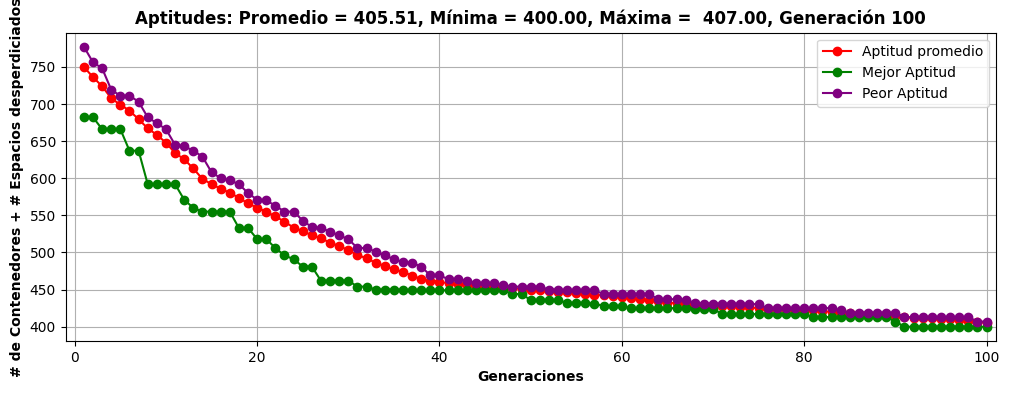

In [99]:
matriz_con_aptitud = algoritmo_genetico_bin_packing(pob, CONFIGURACIONES_CAJAS[0], 100)

In [100]:
print("CANTIDAD DE CAJAS ACOMODADAS: ", cuenta_cajas(matriz_con_aptitud["POBLACION"][0]))
print("CONTENEDORES DEL INDIVIDUO MAS APTO: ", len(matriz_con_aptitud["POBLACION"][0]))
print("ESPACIOS VACIOS DESPERDICIADOS DEL INDIVIDUO MAS APTO: ", cuenta_espacios_vacios(matriz_con_aptitud["POBLACION"][0]))
matriz_con_aptitud["POBLACION"][0]

CANTIDAD DE CAJAS ACOMODADAS:  [165 214 193 201 227]
CONTENEDORES DEL INDIVIDUO MAS APTO:  145
ESPACIOS VACIOS DESPERDICIADOS DEL INDIVIDUO MAS APTO:  255


[{'COL_CONT': [1, 1, 1],
  'TOT_CAJ': array([0, 2, 1, 1, 2]),
  'TOT_CAJ_COL': [array([0, 0, 1, 1, 0]),
   array([0, 1, 0, 0, 1]),
   array([0, 1, 0, 0, 1])]},
 {'COL_CONT': [1, 1, 0],
  'TOT_CAJ': array([2, 1, 1, 1, 2]),
  'TOT_CAJ_COL': [array([0, 0, 1, 1, 0]),
   array([0, 1, 0, 0, 1]),
   array([2, 0, 0, 0, 1])]},
 {'COL_CONT': [1, 1, 0],
  'TOT_CAJ': array([1, 2, 2, 0, 2]),
  'TOT_CAJ_COL': [array([0, 1, 0, 0, 1]),
   array([0, 1, 0, 0, 1]),
   array([1, 0, 2, 0, 0])]},
 {'COL_CONT': [0, 0, 0],
  'TOT_CAJ': array([2, 0, 4, 2, 0]),
  'TOT_CAJ_COL': [array([0, 0, 0, 2, 0]),
   array([1, 0, 2, 0, 0]),
   array([1, 0, 2, 0, 0])]},
 {'COL_CONT': [1, 1, 0],
  'TOT_CAJ': array([2, 2, 0, 0, 3]),
  'TOT_CAJ_COL': [array([0, 1, 0, 0, 1]),
   array([0, 1, 0, 0, 1]),
   array([2, 0, 0, 0, 1])]},
 {'COL_CONT': [1, 0, 1],
  'TOT_CAJ': array([1, 1, 3, 1, 1]),
  'TOT_CAJ_COL': [array([0, 0, 1, 1, 0]),
   array([1, 0, 2, 0, 0]),
   array([0, 1, 0, 0, 1])]},
 {'COL_CONT': [1, 1, 0],
  'TOT_CAJ': ar